# Optimal adjustment simulations

Code by Jacqueline Maasch | April 2025

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
import platform
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from os import listdir
from os.path import isfile, join
import itertools
#plt.rcParams["figure.figsize"] = (2,2)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import networkx as nx
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from sklearn.ensemble import (RandomForestRegressor,RandomForestClassifier,
                              GradientBoostingRegressor,GradientBoostingClassifier)
from dowhy import CausalModel
import dowhy.datasets

# Custom scripts.
from effect_estimation import Estimator
from data_generation import DataGenerator
from utils import Utils

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)

python version     : 3.10.13
numpy version      : 1.26.3
pandas version     : 2.1.4
matplotlib version : 3.8.0
seaborn version    : 0.12.2


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Generate data

In [2]:
dg = DataGenerator()
u = Utils()

In [3]:
# Test single sample.
n = 1000
coefficient_range = (1.1, 1.25)
xy_coeff = 1.0
x_causes_y = True

df, g = dg.get_data_lemma_8(n = n, 
                            x_causes_y = x_causes_y,
                            xy_coeff = xy_coeff,
                            coefficient_range = coefficient_range)

In [4]:
display(df.head())

,A,Y,B1,G1,G2
0,-1.325519,-5.395680,-2.491866,-3.314660,-0.673985
1,0.308221,0.608789,-0.030237,-0.771326,0.433098
2,-0.146166,-4.029977,-0.240823,-1.720210,-0.864585
3,0.740149,6.525472,2.575989,4.087716,1.137297
4,-1.066661,-4.010388,-2.238819,-1.511246,0.079828


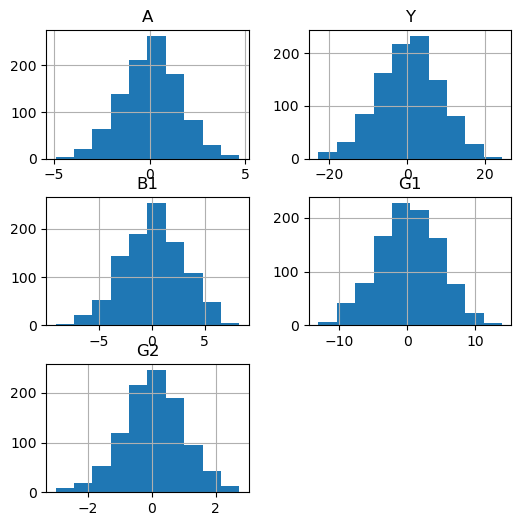

In [5]:
_ = df.hist(figsize = (6,6))
plt.show()

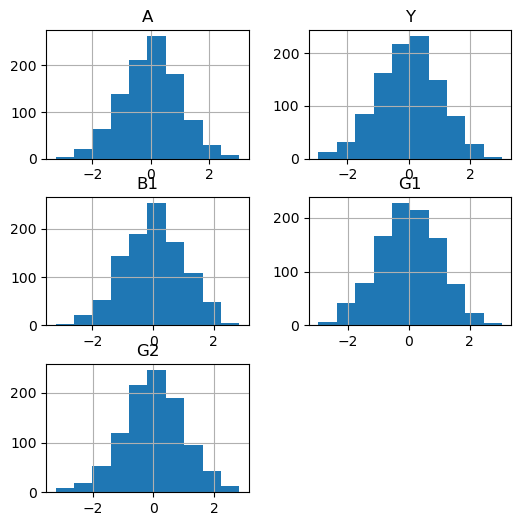

In [6]:
# Scale data.
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_values, columns = df.columns)
_ = scaled_df.hist(figsize = (6,6))
plt.show()

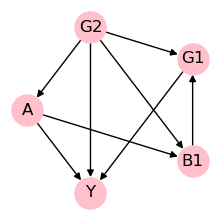

In [7]:
u.plot_from_graph(g, figsize = (2,2), dpi = 100, node_size = 500)

In [8]:
# Get replicate samples.
reps = 100
sizes = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
coefficient_range = (1.1, 1.25)
xy_coeff = 1.25
x_causes_y = True
scale = False

df_dict = dict()
for size in sizes:
    dfs = []
    for rep in range(reps):
        df, _ = dg.get_data_lemma_8(n = size, 
                                    x_causes_y = x_causes_y,
                                    xy_coeff = xy_coeff,
                                    coefficient_range = coefficient_range,
                                    scale = scale)
        dfs.append(df)
    df_dict[size] = dfs

In [9]:
len(df_dict.get(5000))

## Estimate WCDE

In [10]:
e = Estimator()
exposure = "A"
outcome = "Y"
covars = ["B1", "G1", "G2"]
powerset = u.get_powerset(covars)
powerset = [list(x) for x in powerset]
colors = ["#FDBC42", "#41B0E4", "#C6DC67", "#F69289", 
          "#7977B8", "#2D2F92", "#F26035", "#3FBC9D"]

In [11]:
# Single estimate.
for adj_set in powerset:
    wcde = e.get_wcde(df = df, 
                      exposure = exposure, 
                      outcome = outcome, 
                      parents = adj_set, 
                      linear_regression = True,
                      verbose = False)
    print(adj_set, ":", wcde)

[] : 5.051602587356178
['B1'] : 1.2092621336476326
['G1'] : 1.1960556877866417
['G2'] : 2.9180983012556307
['B1', 'G1'] : 1.235306261088464
['B1', 'G2'] : 1.2513110222758261
['G1', 'G2'] : 1.2495932973626185
['B1', 'G1', 'G2'] : 1.2489602759025675


### Scale sample size

In [12]:
results = dict()
for adj_set in powerset:
    means = []
    variances = []
    for size,dfs in df_dict.items():
        estimates = []
        for df in dfs:
            wcde = e.get_wcde(df = df, 
                              exposure = exposure, 
                              outcome = outcome, 
                              parents = adj_set, 
                              linear_regression = True,
                              verbose = False)
            estimates.append(wcde)
        means.append(np.mean(estimates))
        variances.append(np.var(estimates))
    results[str(adj_set)] = [means,variances]

In [13]:
for key,value in results.items():
    print(key, ":", value)

[] : [[4.920901484655326, 4.935780781258291, 4.940076930200102, 4.962906190065193, 4.947627529678599, 4.936051536506045, 4.928733113486499], [0.0380696483522956, 0.03580971443063091, 0.033615291557326794, 0.028429995160119764, 0.027643715392787437, 0.028020161362457885, 0.031247526338888085]]
['B1'] : [[1.0934775642031653, 1.1186101429526278, 1.121500247712283, 1.1079167421543925, 1.1111725863970376, 1.1165551834800251, 1.1078410985766438], [0.009879220287908877, 0.00415943915191223, 0.005012213893260221, 0.003566800017621173, 0.003460112069272662, 0.003233764993692422, 0.0024362040945279054]]
['G1'] : [[1.17435734952769, 1.1796026400862045, 1.1823893744336031, 1.178086186832697, 1.179525743931887, 1.1822200141015744, 1.177827973363114], [0.002784017655523621, 0.0007077190090479492, 0.0006981328777031115, 0.000462710232117444, 0.0004166178441456331, 0.0003796626632137751, 0.0002932753501646525]]
['G2'] : [[2.851308854365744, 2.8737471393339376, 2.873307185154414, 2.886067887022741, 2.8

## Plot results

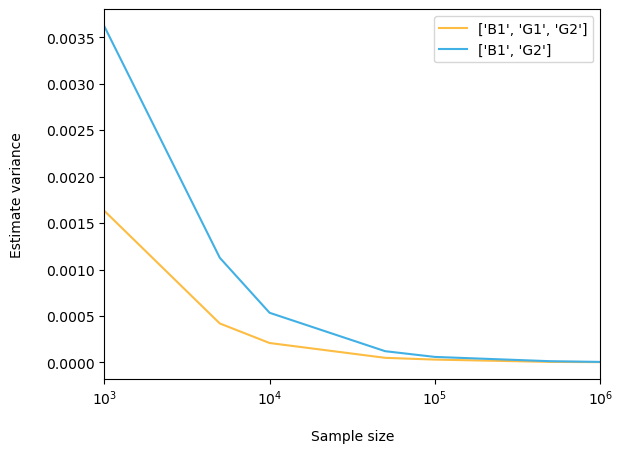

In [14]:
# Compare G2,B1 and G2,B1,G1.
plt.plot(sizes, 
         results.get("['B1', 'G1', 'G2']")[1], 
         label = "['B1', 'G1', 'G2']", 
         color = colors[0])
plt.plot(sizes, 
         results.get("['B1', 'G2']")[1],
         label = "['B1', 'G2']", 
         color = colors[1])
plt.legend(loc = 'upper right')
plt.xlabel('\nSample size')
plt.ylabel('Estimate variance\n')
plt.xlim(sizes[0],sizes[-1])
plt.xscale('symlog')
plt.show()

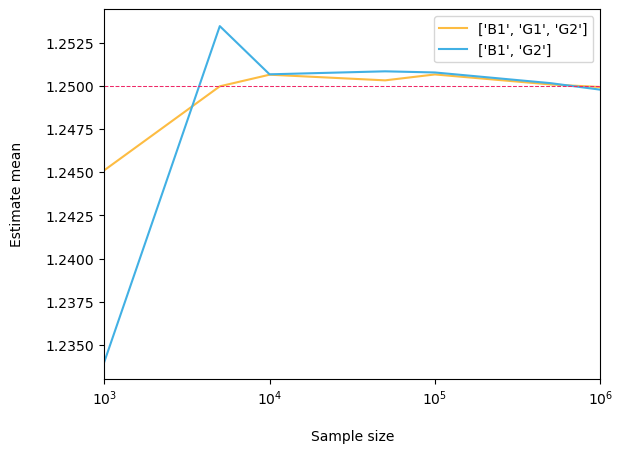

In [15]:
# Compare G2,B1 and G2,B1,G1.
plt.plot(sizes, 
         results.get("['B1', 'G1', 'G2']")[0], 
         label = "['B1', 'G1', 'G2']", 
         color = colors[0])
plt.plot(sizes, 
         results.get("['B1', 'G2']")[0],
         label = "['B1', 'G2']", 
         color = colors[1])
plt.axhline(y = xy_coeff, color = '#EE2967', linestyle = '--', linewidth = 0.75)
plt.legend(loc = 'upper right')
plt.xlabel('\nSample size')
plt.ylabel('Estimate mean\n')
plt.xlim(sizes[0],sizes[-1])
plt.xscale('symlog')
plt.show()

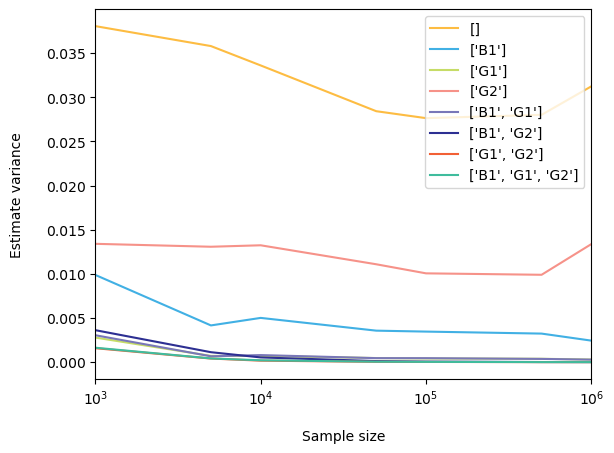

In [16]:
i = 0
for key,value in results.items():
    plt.plot(sizes, value[1], label = key, color = colors[i])
    i += 1
plt.legend(loc = 'upper right')
plt.xlabel('\nSample size')
plt.ylabel('Estimate variance\n')
plt.xlim(sizes[0],sizes[-1])
plt.xscale('symlog')
plt.show()

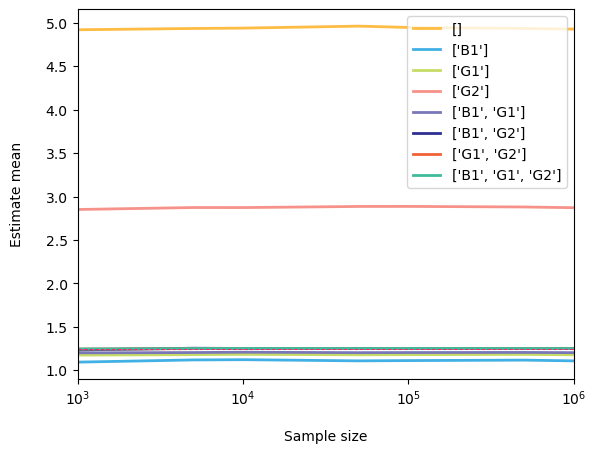

In [17]:
i = 0
for key,value in results.items():
    plt.plot(sizes, value[0], label = key, color = colors[i], linewidth = 2)
    i += 1
plt.legend(loc = 'upper right')
plt.xlabel('\nSample size')
plt.ylabel('Estimate mean\n')
plt.axhline(y = xy_coeff, color = '#EE2967', linestyle = '--', linewidth = 0.75)
plt.xlim(sizes[0],sizes[-1])
plt.xscale('symlog')
plt.show()